In [94]:
import numpy as np
import os
import mne
import pandas as pd
import hmp 
import matplotlib.pyplot as plt
import random

In [95]:
def extract_timecourse_one_session(files, session_str, tmin, n_comp, location):
    """
    Extracts, preprocesses, and fits HMP models for a single session across multiple subjects.

    Parameters:
    - files (list of str): List of file names containing EEG data (e.g., .fif files).
    - session_str (str): String used to identify files corresponding to the session of interest.

    Returns:
    - models_dict (dict): Dictionary mapping subject IDs to their corresponding:
        - 'model': fitted HMP model object
        - 'epoch_data': preprocessed epoch-level data
        - 'init': initialization of model

    Notes:
    - Filters annotations to include only events corresponding to start and end of trial (reasoning part of experiment)
    - Applies HMP model fitting per subject.
    """
    models_dict = {}

    for file in files: 
        if session_str in file.split('_')[1][2:4]:
            print(f"Processing file: {file}")
            
            # 1. Read data
            raw = mne.io.read_raw_fif(os.path.join(epoch_data_path, file), preload=True)

           # 2. Extract annotations
            annotations = raw.annotations
            onset = annotations.onset
            description = annotations.description

            # 3. Create dataframe
            df = pd.DataFrame({"description": description, "onset": onset})

            # 4. Filter events
            df_filtered = df[df["description"].isin(["stim-all_stim", "trial_end"])].reset_index(drop=True)

            # 5. Map to event IDs
            mapping = {"stim-all_stim": 1, "trial_end": 2}
            df_filtered["event_id"] = df_filtered["description"].map(mapping)

            # 6. Convert to samples
            sfreq = int(raw.info['sfreq'])
            df_filtered["sample"] = (df_filtered["onset"] * sfreq).astype(int)

            # 7. Create previous column
            df_filtered["previous"] = 0

            # 8. Arrange columns
            df_events = df_filtered[["sample", "previous", "event_id"]]

            # 9. Convert to numpy
            events = df_events.values

            # 10. Define IDs
            event_id = {"stimulus": 1}
            resp_id = {"response": 2}

            # 11. Epoch data
            epoch_data = hmp.utils.read_mne_data(
                os.path.join(epoch_data_path, file),
                event_id=event_id,
                resp_id=resp_id,
                sfreq=500,
                events_provided=events,
                verbose=True,
                tmin=tmin,
                tmax=15
            )
            

            # 12. Transform data
            hmp_data = hmp.utils.transform_data(epoch_data, apply_standard=False, n_comp=n_comp)

            # 13. Initialize model
            model_init = hmp.models.hmp(
                data=hmp_data,
                sfreq=epoch_data.sfreq,
                cpus=4,
                event_width=50,
                distribution='gamma',
                shape=2,
                location=location
            )

            # 14. Fit model
            model = model_init.fit(verbose=False)

            # 15. Store in dictionary
            subject_id = "subject_" + file.split('_')[1][0:2]
            print(f"✅ Storing data for {subject_id}")

            models_dict[subject_id] = {
                "model": model,
                "epoch_data": epoch_data,
                "init": model_init
            }

    return models_dict

In [96]:
# -------------------------------
# Absolute timing (list) for one event
# -------------------------------

def event_abs_timing_list(eventprobs, event_n):
    """
    For a given event number, finds the time point in each trial where the event has the highest probability.

    Args:
        eventprobs: 3D array (trials × samples × events), probabilities for each event over time.
        event_n: Integer index of the event of interest.

    Returns:
        List of time indices (one per trial) where the given event is most probable (in sample indices).
    """
    trial_results = []

    for trial in range(len(eventprobs)):
        trial_probs = [eventprobs[trial][sample][event_n] for sample in range(len(eventprobs[trial]))]
        max_idx = trial_probs.index(max(trial_probs))
        trial_results.append(max_idx)

    return trial_results

# -------------------------------
# Absolute timing (DataFrame) for all events
# -------------------------------

def event_abs_timing_df(eventprobs, n_events):
    """
    Constructs a DataFrame showing, for each event, the sample index at which that event
    had the highest probability across trials.

    Args:
        eventprobs: 3D array (trials × samples × events), probabilities for each event over time.
        n_events: Integer, number of events.

    Returns:
        DataFrame of shape (trials × events), with each entry being the sample index of peak probability.
    """
    abs_timing_dict = {}

    for event in range(n_events):
        abs_timing_list = event_abs_timing_list(eventprobs, event)
        abs_timing_dict[event] = abs_timing_list

    return pd.DataFrame(abs_timing_dict)

# -------------------------------
# Relative timing (list) for one event
# -------------------------------

def event_rel_timing_list(eventprobs, rt, event_n):
    """
    Calculate the relative timing of a specific event within each trial,
    expressed as a proportion of the reaction time.

    Args:
        eventprobs: 3D array (trials × samples × events), probabilities for each event over time.
        rt: List of reaction times (in seconds), one per trial.
        event_n: Integer index of the event of interest.

    Returns:
        List of relative timings (one per trial).
    """
    trial_results = []

    for trial in range(len(eventprobs)):
        trial_probs = [eventprobs[trial][sample][event_n] for sample in range(len(eventprobs[trial]))]
        max_idx = trial_probs.index(max(trial_probs))

        # Convert sample index to milliseconds (500 Hz = 2 ms per sample)
        event_ms = max_idx * 2
        rt_ms = rt[trial] * 1000

        trial_results.append(event_ms / rt_ms)

    return trial_results

# -------------------------------
# Relative timing (DataFrame) for all events
# -------------------------------

def event_rel_timing_df(eventprobs, rt, n_events):
    """
    Constructs a DataFrame showing, for each event, the relative timing (as a proportion of total trial duration)
    at which that event had the highest probability across trials.

    Args:
        eventprobs: 3D array (trials × samples × events), probabilities for each event over time.
        rt: List or array of reaction times (in seconds), one per trial.
        n_events: Integer, number of events.

    Returns:
        DataFrame with shape (trials x events), with each value being the relative timing of peak probability.
    """
    rel_timing_dict = {}

    for event in range(n_events):
        rel_timing_list = event_rel_timing_list(eventprobs, rt, event)
        rel_timing_dict[event] = rel_timing_list

    return pd.DataFrame(rel_timing_dict)

In [97]:
# -------------------------------
# Average EEG topomap for a single event
# -------------------------------

def average_map_for_event(event_timing_list, epoch_data):
    """
    Computes the average topographic map at given event timepoints across all trials.

    Args:
        event_timing_list: List of sample indices per trial for the event.
        epoch_data: Xarray with dimensions (participants x epochs × channels × samples).
    
    Returns:
        1D numpy array representing the average topographic map (mean over trials).
    """
    all_maps = []
    for idx, sample_idx in enumerate(event_timing_list):
        # index [0] removes the participant dimension (only one participant processed at a time)
        values = epoch_data.isel(epochs=idx, samples=sample_idx).data.values[0]
        all_maps.append(values)
    
    all_maps_array = np.array(all_maps)
    avg_map = np.mean(all_maps_array, axis=0)
    return avg_map

# -------------------------------
# Mean spatial correlation across trials for each event (absolute or signed)
# -------------------------------

def corr_maps_per_event(event_abs_timing_df, epoch_data, absolute=False):
    """
    Calculates the mean spatial correlation of EEG topographies across trials for each event.

    Args:
        event_abs_timing_df: DataFrame with sample indices per trial (from event_abs_timing_df) for each event. 
        epoch_data: Xarray with dimensions (participants × epochs × channels × samples).
        absolute: Bool, if True computes absolute correlations (ignores polarity).
                  If False computes signed correlations.

    Returns:
        List of mean pairwise correlations between topographies for each event.
    """
    event_corr_list = []

    for event in event_abs_timing_df.columns:
        matrix_of_values = []
        list_timing = event_abs_timing_df[event]

        for idx, sample_idx in enumerate(list_timing):
            # index [0] removes the participant dimension (only one participant processed at a time)
            values = epoch_data.isel(epochs=idx, samples=sample_idx).data.values[0]
            matrix_of_values.append(values)

        matrix_df = pd.DataFrame(matrix_of_values)
        similarity_matrix = matrix_df.T.corr()

        if absolute:
            similarity_matrix = similarity_matrix.abs()

        upper_triangle = similarity_matrix.where(np.triu(np.ones(similarity_matrix.shape), k=1).astype(bool))
        mean_corr = upper_triangle.stack().mean()
        event_corr_list.append(mean_corr)

    return event_corr_list

# -------------------------------
# Subject-wise event correlations
# -------------------------------

def compute_subjectwise_event_correlations(models_dict):
    """
    Runs the spatial correlation analysis pipeline for each subject.

    Returns:
    - Dictionary mapping each subject to a list of mean event correlations.
    """
    maps_corr_dict = {}

    for subject in models_dict:
        print(f"Starting subject: {subject}", flush=True)

        model = models_dict[subject]["model"]
        epoch_data = models_dict[subject]["epoch_data"]

        eventprobs = model.eventprobs.values
        n_events = eventprobs.shape[2]

        # Get sample indices of peak event probabilities
        event_abs_timing_df_ = event_abs_timing_df(eventprobs, n_events)

        # Compute mean spatial correlation per event
        event_corr_list = corr_maps_per_event(event_abs_timing_df_, epoch_data)

        maps_corr_dict[subject] = event_corr_list
        print(f"✅ Finished {subject}", flush=True)

    return maps_corr_dict

In [98]:
# -------------------------------
# Shuffled average map + correlation (absolute or signed) for one event
# -------------------------------

def compute_shuffled_event_topography(event_rel_timing_df, epoch_data, event_n, absolute=False):
    """
    Computes the shuffled average brain map and its mean (absolute or signed) spatial correlation 
    across trials for a single event.

    Args:
        event_rel_timing_df: DataFrame with relative event timings (0–1) for each trial and event.
        epoch_data: Xarray with dimensions (participants × epochs × channels × samples).
        event_n: Integer, index of the event to shuffle.
        absolute: Bool, if True computes absolute correlations (ignores polarity). 
                  If False computes signed correlations.

    Returns:
        avg_map: 1D numpy array, the average topographic map after shuffling.
        mean_corr: Float, mean pairwise spatial correlation across shuffled trial maps.
    """
    all_maps = []

    # Shuffle event timings across trials
    rel_timing_list = event_rel_timing_df[event_n].tolist()
    random.shuffle(rel_timing_list)

    # Loop through trials with permuted timings
    for idx, rel_sample_idx in enumerate(rel_timing_list):
        rt_ms = epoch_data.rt.values[idx] * 1000  # convert to ms
        sample_idx = round(rel_sample_idx * rt_ms * 0.5)  # 500 Hz = 0.5 samples/ms
        values = epoch_data.isel(epochs=idx, samples=sample_idx).data.values[0]
        all_maps.append(values)

    # Convert to array
    all_maps_array = np.array(all_maps)

    # Compute average map
    avg_map = np.mean(all_maps_array, axis=0)

    # Compute spatial correlation across maps
    matrix_df = pd.DataFrame(all_maps_array)
    similarity_matrix = matrix_df.T.corr()

    if absolute:
        similarity_matrix = similarity_matrix.abs()

    upper_triangle = similarity_matrix.where(np.triu(np.ones(similarity_matrix.shape), k=1).astype(bool))
    mean_corr = upper_triangle.stack().mean()

    return avg_map, mean_corr


# -------------------------------
# Null distribution of event correlations (absolute or signed)
# -------------------------------

def generate_null_distribution_event_corr(epoch_data, event_rel_timing_df, n_perm, absolute=False):
    """
    Creates a null distribution of average spatial correlations (absolute or signed) 
    by randomly permuting event timings across trials.

    Args:
        epoch_data: Xarray with dimensions (participants × epochs × channels × samples), and .rt values in seconds.
        event_rel_timing_df: DataFrame with relative event timings (0–1) for each trial and event.
        n_perm: Number of permutations to run.
        absolute: Bool, if True computes absolute correlations (ignores polarity). 
                  If False computes signed correlations.

    Returns:
        List of lists: each inner list contains mean event correlations for one permutation.
    """
    results = []

    for perm in range(n_perm):
        event_corr_list = []

        for event in event_rel_timing_df.columns:
            matrix_of_values = []

            # Shuffle event timings across trials
            rel_timing_list = event_rel_timing_df[event].tolist().copy()
            random.shuffle(rel_timing_list)

            # Extract trial maps at shuffled timepoints
            for idx, rel_sample_time in enumerate(rel_timing_list):
                rt_ms = epoch_data.rt.values[idx] * 1000  
                sample_idx = round(rel_sample_time * rt_ms * 0.5)  # 500 Hz = 0.5 samples/ms
                values = epoch_data.isel(epochs=idx, samples=sample_idx).data.values[0]
                matrix_of_values.append(values)

            # Compute mean pairwise correlation across maps
            matrix_df = pd.DataFrame(matrix_of_values)
            similarity_matrix = matrix_df.T.corr()
            if absolute:
                similarity_matrix = similarity_matrix.abs()
            upper_triangle = similarity_matrix.where(np.triu(np.ones(similarity_matrix.shape), k=1).astype(bool))
            mean_corr = upper_triangle.stack().mean()

            event_corr_list.append(mean_corr)

        results.append(event_corr_list)

    return results

# -------------------------------
# Significance of observed vs. null correlations
# -------------------------------

def compute_event_corr_significance(observed_list, permuted_lists, event_labels=None):
    """
    Computes z-scores and one-tailed p-values for event-wise mean spatial correlations
    by comparing to a null distribution generated via permutation.

    Args:
        observed_list: List of observed mean correlations (one per event).
        permuted_lists: List of lists (n_permutations × n_events) from permutation function.
        event_labels: Optional list of event names. If None, defaults to 'event_0', 'event_1', ...

    Returns:
        z_scores_df, p_values_df: DataFrames with shape (1 × n_events), containing z-scores and p-values.
    """
    null_matrix = np.array(permuted_lists)  # shape: (n_permutations, n_events)
    observed_array = np.array(observed_list)  # shape: (n_events,)

    mean_null = np.mean(null_matrix, axis=0)
    std_null = np.std(null_matrix, axis=0) + 1e-8  # avoid division by zero

    # Z-scores
    z_scores = (observed_array - mean_null) / std_null

    # One-tailed p-values: proportion of permuted values as or more extreme than observed values
    p_values = (null_matrix >= observed_array[None, :]).mean(axis=0) 

    if event_labels is None:
        event_labels = [f"event_{i}" for i in range(len(observed_array))]

    z_df = pd.DataFrame([z_scores], columns=event_labels, index=["z_score"])
    p_df = pd.DataFrame([p_values], columns=event_labels, index=["p_value"])

    return z_df, p_df

In [99]:
# -------------------------------
# Plot time course per subject
# -------------------------------

def plot_timecourses(model_dict, correlation_dict, positions):
    """
    Plots time course for each subject.

    Parameters:
    - model_dict (dict): Contains 'model', 'epoch_data', and 'init' for each subject.
    - correlation_dict (dict): Mean spatial correlation values per subject.
    - positions: Sensor/electrode positions for topographic plotting.
    """
    # Plot time course for each subject
    for subject in correlation_dict:
        model_info = model_dict[subject]
        model = model_info["model"]
        epoch_data = model_info["epoch_data"]
        init = model_info["init"]
        mean_corr = correlation_dict[subject]

        # Create and show figure
        plt.figure(figsize=(10, 4))
        hmp.visu.plot_topo_timecourse(epoch_data, model,
                                      positions, init,
                                      magnify=1, sensors=False,
                                      as_time=True)
        plt.suptitle(f"{subject} – Event Corr: {mean_corr:.3f}")
        plt.show()

# Analysis of Event-wise Spatial Consistency (Session 3)

In [100]:
# -------------------------------
# Load data and path
# -------------------------------
epoch_data_path = os.path.join(os.getcwd())
files = [x for x in os.listdir(epoch_data_path) if "preprocessed-raw.fif" in x]

In [101]:
# -------------------------------
# HMP fitting
# -------------------------------
models_third_session = extract_timecourse_one_session(files, "03", -0.2, 10, 50)

Processing file: subj_0203_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0203_preprocessed-raw.fif...
    Range : 0 ... 2918399 =      0.000 ...  1425.000 secs
Ready.
Reading 0 ... 2918399  =      0.000 ...  1425.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0203_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0203_preprocessed-raw.fif...
    Range : 0 ... 2918399 =      0.000 ...  1425.000 secs
Ready.
Reading 0 ... 2918399  =      0.000 ...  1425.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 165.16 Hz
- Upper tra

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0203_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/879 [00:00<?, ?it/s]

✅ Storing data for subject_02
Processing file: subj_0403_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0403_preprocessed-raw.fif...
    Range : 0 ... 2779135 =      0.000 ...  1357.000 secs
Ready.
Reading 0 ... 2779135  =      0.000 ...  1357.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0403_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0403_preprocessed-raw.fif...
    Range : 0 ... 2779135 =      0.000 ...  1357.000 secs
Ready.
Reading 0 ... 2779135  =      0.000 ...  1357.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0403_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/976 [00:00<?, ?it/s]

✅ Storing data for subject_04
Processing file: subj_0503_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0503_preprocessed-raw.fif...
    Range : 0 ... 2836479 =      0.000 ...  1385.000 secs
Ready.
Reading 0 ... 2836479  =      0.000 ...  1385.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0503_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0503_preprocessed-raw.fif...
    Range : 0 ... 2836479 =      0.000 ...  1385.000 secs
Ready.
Reading 0 ... 2836479  =      0.000 ...  1385.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0503_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1832 [00:00<?, ?it/s]

✅ Storing data for subject_05
Processing file: subj_0603_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0603_preprocessed-raw.fif...
    Range : 0 ... 3172351 =      0.000 ...  1549.000 secs
Ready.
Reading 0 ... 3172351  =      0.000 ...  1549.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0603_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0603_preprocessed-raw.fif...
    Range : 0 ... 3172351 =      0.000 ...  1549.000 secs
Ready.
Reading 0 ... 3172351  =      0.000 ...  1549.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0603_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1871 [00:00<?, ?it/s]

✅ Storing data for subject_06
Processing file: subj_0803_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0803_preprocessed-raw.fif...
    Range : 0 ... 2725887 =      0.000 ...  1331.000 secs
Ready.
Reading 0 ... 2725887  =      0.000 ...  1331.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0803_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0803_preprocessed-raw.fif...
    Range : 0 ... 2725887 =      0.000 ...  1331.000 secs
Ready.
Reading 0 ... 2725887  =      0.000 ...  1331.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0803_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/720 [00:00<?, ?it/s]

C:\Users\celia\AppData\Local\Programs\Python\Python313\Lib\site-packages\hmp\models.py:782: RuntimeWarning: invalid value encountered in scalar divide
  if i >= min_iteration and (np.isneginf(lkh) or tolerance > (lkh-lkh_prev)/np.abs(lkh_prev)):
C:\Users\celia\AppData\Local\Programs\Python\Python313\Lib\site-packages\hmp\models.py:782: RuntimeWarning: invalid value encountered in scalar divide
  if i >= min_iteration and (np.isneginf(lkh) or tolerance > (lkh-lkh_prev)/np.abs(lkh_prev)):
C:\Users\celia\AppData\Local\Programs\Python\Python313\Lib\site-packages\hmp\models.py:782: RuntimeWarning: invalid value encountered in scalar divide
  if i >= min_iteration and (np.isneginf(lkh) or tolerance > (lkh-lkh_prev)/np.abs(lkh_prev)):


✅ Storing data for subject_08
Processing file: subj_0903_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0903_preprocessed-raw.fif...
    Range : 0 ... 3944447 =      0.000 ...  1926.000 secs
Ready.
Reading 0 ... 3944447  =      0.000 ...  1926.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0903_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0903_preprocessed-raw.fif...
    Range : 0 ... 3944447 =      0.000 ...  1926.000 secs
Ready.
Reading 0 ... 3944447  =      0.000 ...  1926.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_0903_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/560 [00:00<?, ?it/s]

✅ Storing data for subject_09
Processing file: subj_1003_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1003_preprocessed-raw.fif...
    Range : 0 ... 2246655 =      0.000 ...  1097.000 secs
Ready.
Reading 0 ... 2246655  =      0.000 ...  1097.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1003_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1003_preprocessed-raw.fif...
    Range : 0 ... 2246655 =      0.000 ...  1097.000 secs
Ready.
Reading 0 ... 2246655  =      0.000 ...  1097.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.1s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1003_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/932 [00:00<?, ?it/s]

✅ Storing data for subject_10
Processing file: subj_1103_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1103_preprocessed-raw.fif...
    Range : 0 ... 2572287 =      0.000 ...  1256.000 secs
Ready.
Reading 0 ... 2572287  =      0.000 ...  1256.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1103_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1103_preprocessed-raw.fif...
    Range : 0 ... 2572287 =      0.000 ...  1256.000 secs
Ready.
Reading 0 ... 2572287  =      0.000 ...  1256.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1103_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1343 [00:00<?, ?it/s]

✅ Storing data for subject_11
Processing file: subj_1203_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1203_preprocessed-raw.fif...
    Range : 0 ... 2463743 =      0.000 ...  1203.000 secs
Ready.
Reading 0 ... 2463743  =      0.000 ...  1203.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1203_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1203_preprocessed-raw.fif...
    Range : 0 ... 2463743 =      0.000 ...  1203.000 secs
Ready.
Reading 0 ... 2463743  =      0.000 ...  1203.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
1 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
79 RTs kept of 79 clean epochs
79 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1203_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1548 [00:00<?, ?it/s]

✅ Storing data for subject_12
Processing file: subj_1403_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1403_preprocessed-raw.fif...
    Range : 0 ... 2402303 =      0.000 ...  1173.000 secs
Ready.
Reading 0 ... 2402303  =      0.000 ...  1173.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1403_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1403_preprocessed-raw.fif...
    Range : 0 ... 2402303 =      0.000 ...  1173.000 secs
Ready.
Reading 0 ... 2402303  =      0.000 ...  1173.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
1 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
79 RTs kept of 79 clean epochs
79 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1403_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1669 [00:00<?, ?it/s]

✅ Storing data for subject_14
Processing file: subj_1503_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1503_preprocessed-raw.fif...
    Range : 0 ... 2338815 =      0.000 ...  1142.000 secs
Ready.
Reading 0 ... 2338815  =      0.000 ...  1142.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1503_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1503_preprocessed-raw.fif...
    Range : 0 ... 2338815 =      0.000 ...  1142.000 secs
Ready.
Reading 0 ... 2338815  =      0.000 ...  1142.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1503_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1470 [00:00<?, ?it/s]

C:\Users\celia\AppData\Local\Programs\Python\Python313\Lib\site-packages\hmp\models.py:782: RuntimeWarning: invalid value encountered in scalar divide
  if i >= min_iteration and (np.isneginf(lkh) or tolerance > (lkh-lkh_prev)/np.abs(lkh_prev)):


✅ Storing data for subject_15
Processing file: subj_1603_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1603_preprocessed-raw.fif...
    Range : 0 ... 2387967 =      0.000 ...  1166.000 secs
Ready.
Reading 0 ... 2387967  =      0.000 ...  1166.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1603_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1603_preprocessed-raw.fif...
    Range : 0 ... 2387967 =      0.000 ...  1166.000 secs
Ready.
Reading 0 ... 2387967  =      0.000 ...  1166.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
1 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
79 RTs kept of 79 clean epochs
79 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1603_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1641 [00:00<?, ?it/s]

✅ Storing data for subject_16
Processing file: subj_1703_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1703_preprocessed-raw.fif...
    Range : 0 ... 2287615 =      0.000 ...  1117.000 secs
Ready.
Reading 0 ... 2287615  =      0.000 ...  1117.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1703_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1703_preprocessed-raw.fif...
    Range : 0 ... 2287615 =      0.000 ...  1117.000 secs
Ready.
Reading 0 ... 2287615  =      0.000 ...  1117.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
1 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
79 RTs kept of 79 clean epochs
79 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1703_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1543 [00:00<?, ?it/s]

✅ Storing data for subject_17
Processing file: subj_1903_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1903_preprocessed-raw.fif...
    Range : 0 ... 2371583 =      0.000 ...  1158.000 secs
Ready.
Reading 0 ... 2371583  =      0.000 ...  1158.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1903_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1903_preprocessed-raw.fif...
    Range : 0 ... 2371583 =      0.000 ...  1158.000 secs
Ready.
Reading 0 ... 2371583  =      0.000 ...  1158.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_1903_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1764 [00:00<?, ?it/s]

✅ Storing data for subject_19
Processing file: subj_2003_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2003_preprocessed-raw.fif...
    Range : 0 ... 2803711 =      0.000 ...  1369.000 secs
Ready.
Reading 0 ... 2803711  =      0.000 ...  1369.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2003_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2003_preprocessed-raw.fif...
    Range : 0 ... 2803711 =      0.000 ...  1369.000 secs
Ready.
Reading 0 ... 2803711  =      0.000 ...  1369.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.2s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
80 RTs kept of 80 clean epochs
80 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2003_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1368 [00:00<?, ?it/s]

✅ Storing data for subject_20
Processing file: subj_2203_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2203_preprocessed-raw.fif...
    Range : 0 ... 2293759 =      0.000 ...  1120.000 secs
Ready.
Reading 0 ... 2293759  =      0.000 ...  1120.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2203_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2203_preprocessed-raw.fif...
    Range : 0 ... 2293759 =      0.000 ...  1120.000 secs
Ready.
Reading 0 ... 2293759  =      0.000 ...  1120.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
1 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
79 RTs kept of 79 clean epochs
79 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2203_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/1544 [00:00<?, ?it/s]

✅ Storing data for subject_22
Processing file: subj_2503_preprocessed-raw.fif
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2503_preprocessed-raw.fif...
    Range : 0 ... 1982463 =      0.000 ...   968.000 secs
Ready.
Reading 0 ... 1982463  =      0.000 ...   968.000 secs...
Processing participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2503_preprocessed-raw.fif's continuous eeg
Opening raw data file C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2503_preprocessed-raw.fif...
    Range : 0 ... 1982463 =      0.000 ...   968.000 secs
Ready.
Reading 0 ... 1982463  =      0.000 ...   968.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passba

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
1 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
79 RTs kept of 79 clean epochs
79 trials were retained for participant C:\Users\celia\Desktop\EEG data\Final Notebooks\subj_2503_preprocessed-raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/544 [00:00<?, ?it/s]

✅ Storing data for subject_25


In [102]:
# -------------------------------
# Correlation analysis
# -------------------------------
maps_corr_dict = compute_subjectwise_event_correlations(models_third_session)
mean_corr_across_events = {subject: np.mean(event_corrs) for subject, event_corrs in maps_corr_dict.items()}

Starting subject: subject_02
✅ Finished subject_02
Starting subject: subject_04
✅ Finished subject_04
Starting subject: subject_05
✅ Finished subject_05
Starting subject: subject_06
✅ Finished subject_06
Starting subject: subject_08
✅ Finished subject_08
Starting subject: subject_09
✅ Finished subject_09
Starting subject: subject_10
✅ Finished subject_10
Starting subject: subject_11
✅ Finished subject_11
Starting subject: subject_12
✅ Finished subject_12
Starting subject: subject_14
✅ Finished subject_14
Starting subject: subject_15
✅ Finished subject_15
Starting subject: subject_16
✅ Finished subject_16
Starting subject: subject_17
✅ Finished subject_17
Starting subject: subject_19
✅ Finished subject_19
Starting subject: subject_20
✅ Finished subject_20
Starting subject: subject_22
✅ Finished subject_22
Starting subject: subject_25
✅ Finished subject_25


<Figure size 1000x400 with 0 Axes>

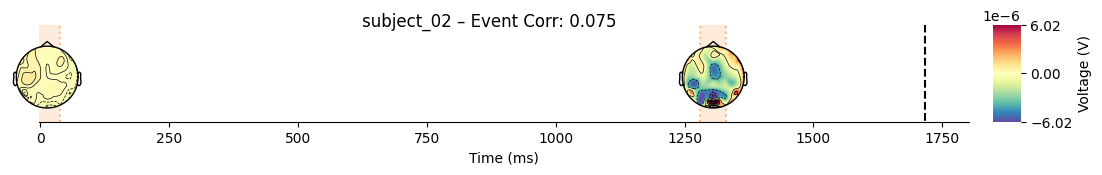

<Figure size 1000x400 with 0 Axes>

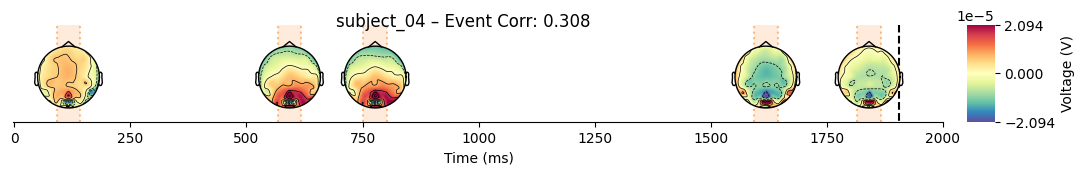

<Figure size 1000x400 with 0 Axes>

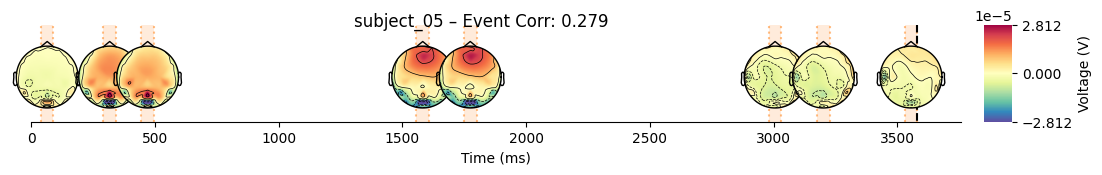

<Figure size 1000x400 with 0 Axes>

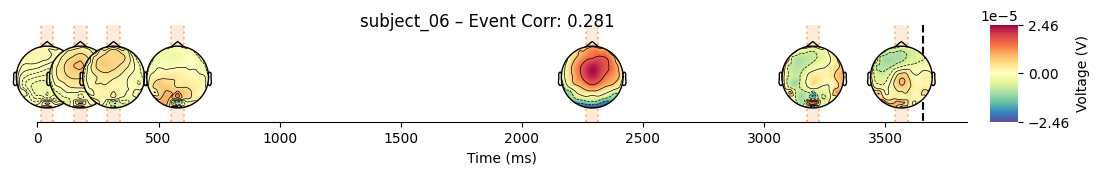

<Figure size 1000x400 with 0 Axes>

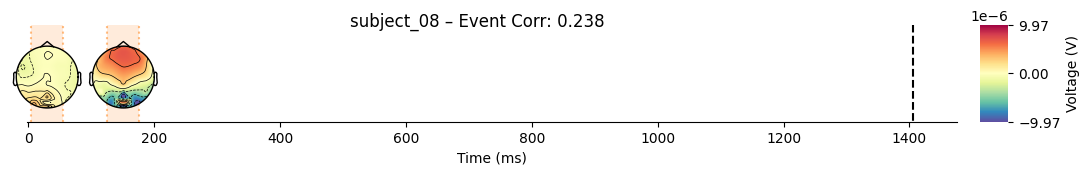

<Figure size 1000x400 with 0 Axes>

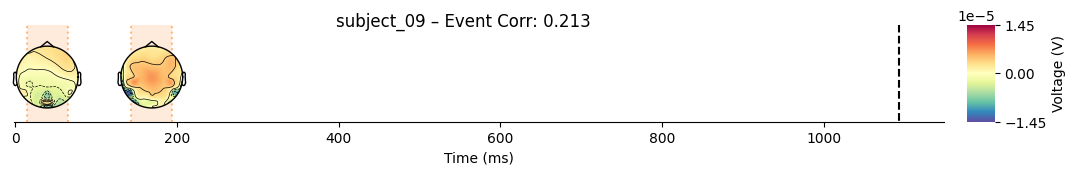

<Figure size 1000x400 with 0 Axes>

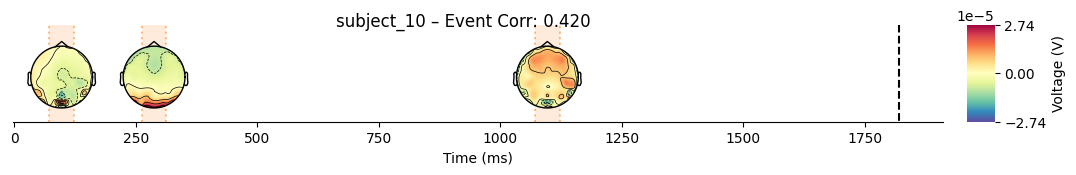

<Figure size 1000x400 with 0 Axes>

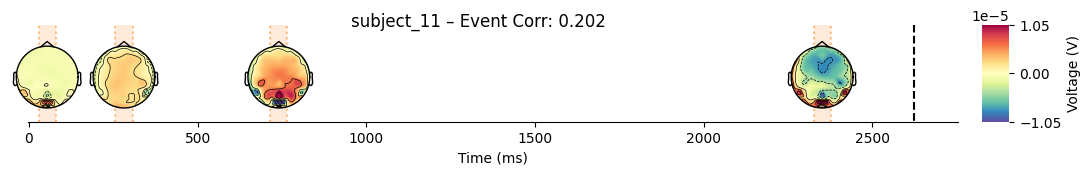

<Figure size 1000x400 with 0 Axes>

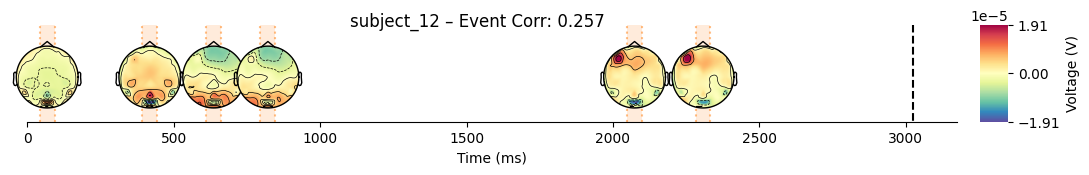

<Figure size 1000x400 with 0 Axes>

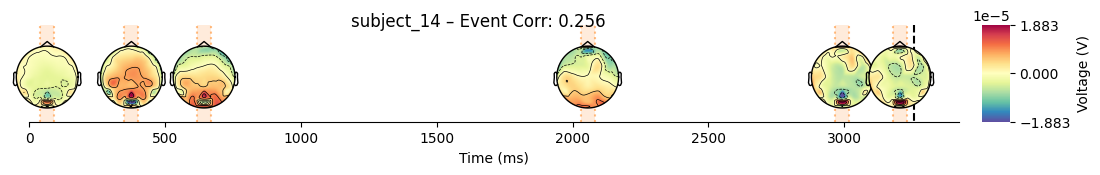

<Figure size 1000x400 with 0 Axes>

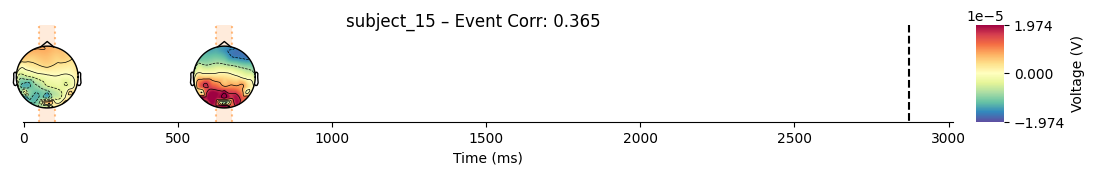

<Figure size 1000x400 with 0 Axes>

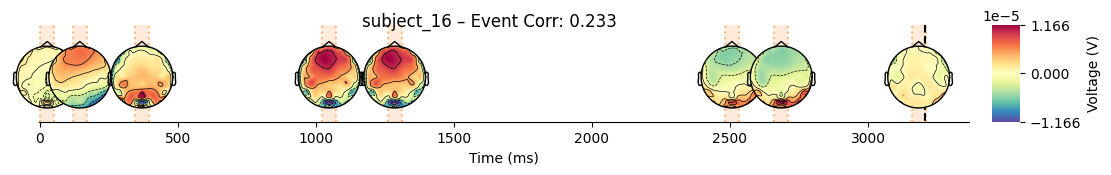

<Figure size 1000x400 with 0 Axes>

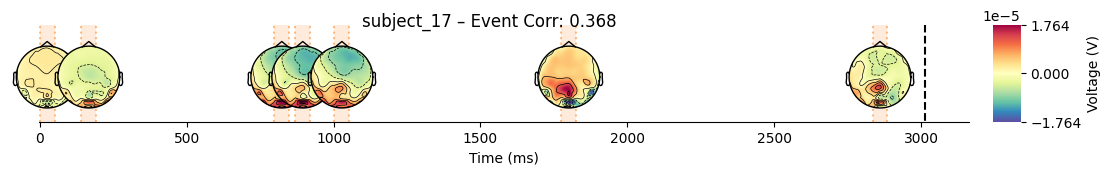

<Figure size 1000x400 with 0 Axes>

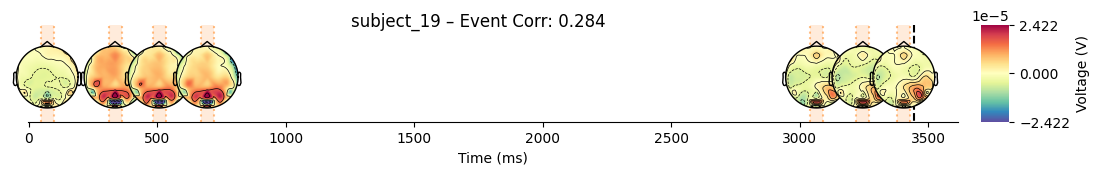

<Figure size 1000x400 with 0 Axes>

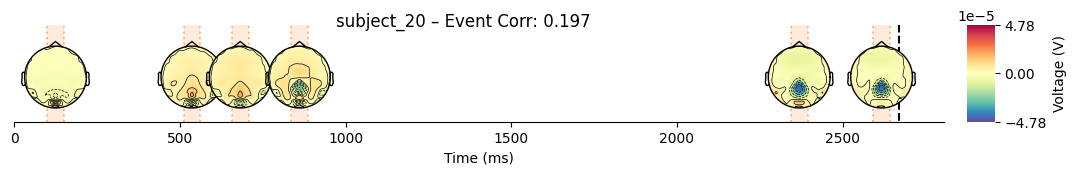

<Figure size 1000x400 with 0 Axes>

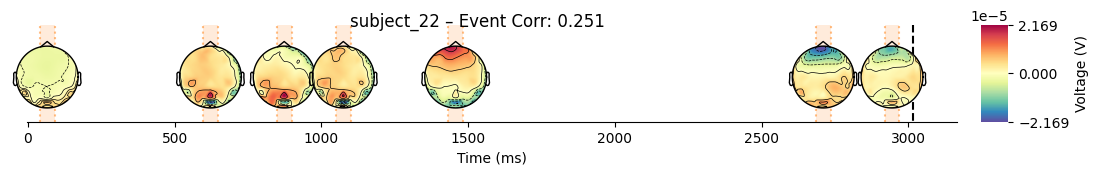

<Figure size 1000x400 with 0 Axes>

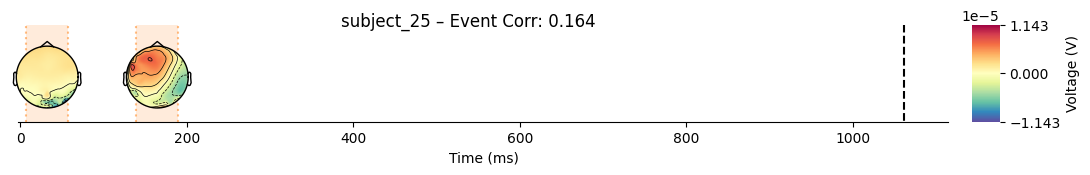

In [103]:
# -------------------------------
# Vizualizations of time courses
# -------------------------------
epoch_data = models_third_session["subject_02"]["epoch_data"]
channel_names = epoch_data.channels.values.tolist()
montage = mne.channels.make_standard_montage('biosemi64')
positions = np.array([montage.get_positions()['ch_pos'][ch][:2] for ch in channel_names])

plot_timecourses(models_third_session, mean_corr_across_events, positions)

In [104]:
# -------------------------------
# Evengt significance analysis
# -------------------------------
significance_dict = {}

for subject in models_third_session:
    print(f"🔄 Processing subject: {subject}", flush=True)
    model = models_third_session[subject]["model"]
    epoch_data = models_third_session[subject]["epoch_data"]
    init = models_third_session[subject]["init"]

    eventprobs = model.eventprobs.values
    n_events = eventprobs.shape[2]
    rt = epoch_data.rt.values

    abs_timing_df = event_abs_timing_df(eventprobs, n_events)
    rel_timing_df = event_rel_timing_df(eventprobs, rt, n_events)

    observed_corr_df = corr_maps_per_event(abs_timing_df, epoch_data, absolute=False)
    permuted_corr_df = generate_null_distribution_event_corr(epoch_data, rel_timing_df, 1000, absolute=False)

    significance_df =  compute_event_corr_significance(observed_corr_df, permuted_corr_df, event_labels=None)

    significance_dict[subject] = significance_df
    print(f"✅ Finished subject: {subject}", flush=True)

🔄 Processing subject: subject_02
✅ Finished subject: subject_02
🔄 Processing subject: subject_04
✅ Finished subject: subject_04
🔄 Processing subject: subject_05
✅ Finished subject: subject_05
🔄 Processing subject: subject_06
✅ Finished subject: subject_06
🔄 Processing subject: subject_08
✅ Finished subject: subject_08
🔄 Processing subject: subject_09
✅ Finished subject: subject_09
🔄 Processing subject: subject_10
✅ Finished subject: subject_10
🔄 Processing subject: subject_11
✅ Finished subject: subject_11
🔄 Processing subject: subject_12
✅ Finished subject: subject_12
🔄 Processing subject: subject_14
✅ Finished subject: subject_14
🔄 Processing subject: subject_15
✅ Finished subject: subject_15
🔄 Processing subject: subject_16
✅ Finished subject: subject_16
🔄 Processing subject: subject_17
✅ Finished subject: subject_17
🔄 Processing subject: subject_19
✅ Finished subject: subject_19
🔄 Processing subject: subject_20
✅ Finished subject: subject_20
🔄 Processing subject: subject_22
✅ Finis

In [105]:
# -------------------------------
# Print subject-wise event correlations and p-values
# -------------------------------
for subject in significance_dict:
    z_df, p_df = significance_dict[subject]
    corr_list = maps_corr_dict[subject]
    corr_df = pd.DataFrame([corr_list], index=["corr"], columns=p_df.columns)
    combined_df = pd.concat([corr_df, p_df])
    
    print(f"\n📊 Results for {subject}:")
    print(combined_df.to_string())


📊 Results for subject_02:
          event_0   event_1
corr     0.016161  0.133245
p_value  0.039000  0.000000

📊 Results for subject_04:
          event_0   event_1   event_2   event_3   event_4
corr     0.327912  0.457383  0.443723  0.224451  0.085423
p_value  0.000000  0.000000  0.000000  0.000000  0.000000

📊 Results for subject_05:
          event_0   event_1   event_2   event_3   event_4   event_5   event_6   event_7
corr     0.112557  0.616165  0.486535  0.476599  0.438018  0.040817  0.041445  0.019534
p_value  0.000000  0.000000  0.000000  0.000000  0.000000  0.091000  0.015000  0.535000

📊 Results for subject_06:
          event_0  event_1  event_2  event_3   event_4   event_5   event_6
corr     0.044352   0.2346  0.20818   0.2747  0.684805  0.290619  0.230391
p_value  0.000000   0.0000  0.00000   0.0000  0.000000  0.000000  0.000000

📊 Results for subject_08:
          event_0   event_1
corr     0.039578  0.436346
p_value  0.007000  0.000000

📊 Results for subject_09:
       

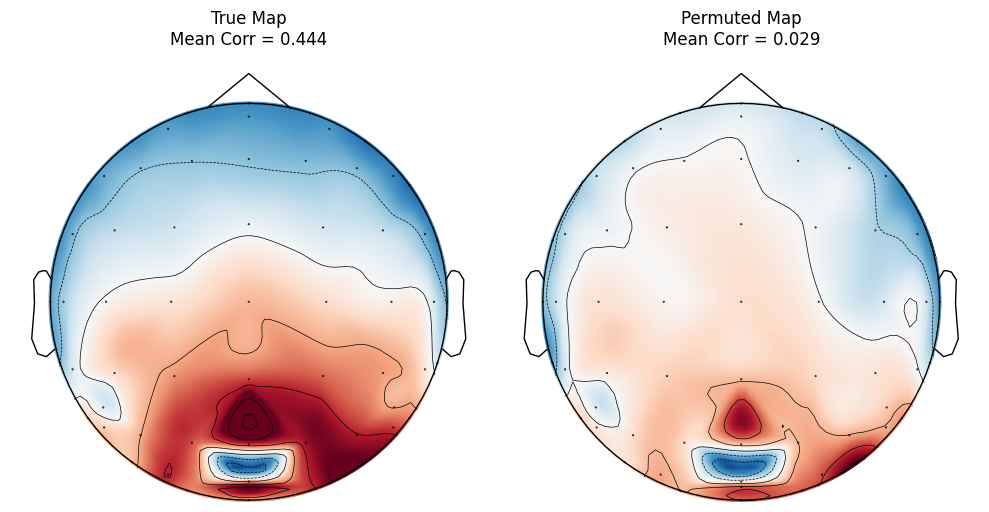

In [109]:
# -------------------------------
# "True" average map versus permuted average map
# -------------------------------
model = models_third_session["subject_04"]["model"]
epoch_data = models_third_session["subject_04"]["epoch_data"]
rt = epoch_data.rt.values
eventprobs = model.eventprobs.values
n_events = eventprobs.shape[2]

abs_event_timing_list = event_abs_timing_list(eventprobs, 2)
rel_event_timing_df = event_rel_timing_df(eventprobs, rt, n_events)

true_avg_map = average_map_for_event(abs_event_timing_list, epoch_data)
true_corr = corr_dict["subject_04"][2]

permuted_avg_map, permuted_corr = compute_shuffled_event_topography(rel_event_timing_df, epoch_data, 2, absolute=False)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

mne.viz.plot_topomap(true_avg_map, positions, axes=axes[0], show=False)
axes[0].set_title(f"True Map\nMean Corr = {true_corr:.3f}")

mne.viz.plot_topomap(permuted_avg_map, positions, axes=axes[1], show=False)
axes[1].set_title(f"Permuted Map\nMean Corr = {permuted_corr:.3f}")

plt.tight_layout()
plt.show()